# 🤖 RNN聊天機器人

基於PyTorch的序列到序列(Seq2Seq)模型，使用Luong注意力機制的聊天機器人。
此版本專為Google Colab環境優化，每次執行都會重新訓練模型，充分利用GPU加速。

In [ ]:
# 1. 環境設置和GPU檢測
import torch
import os

print("=" * 60)
print("🔄 RNN聊天機器人 - Google Colab重新訓練版本")
print("=" * 60)
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU設備: {torch.cuda.get_device_name(0)}")
    print(f"GPU記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    device = torch.device("cuda")
    print(f"✅ 使用GPU加速訓練: {device}")
else:
    device = torch.device("cpu")
    print(f"⚠️ 使用CPU訓練: {device}")

print("=" * 60)
print("⚠️ 注意：此版本每次執行都會重新訓練模型")
print("=" * 60)

🔄 RNN聊天機器人 - Google Colab重新訓練版本
PyTorch版本: 2.8.0+cu126
CUDA可用: True
GPU設備: Tesla T4
GPU記憶體: 14.7 GB
✅ 使用GPU加速訓練: cuda
⚠️ 注意：此版本每次執行都會重新訓練模型


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,274 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,371 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,6

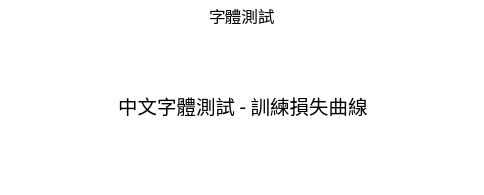

✅ NLTK數據下載完成


In [ ]:
# 2. 安裝依賴套件和中文字體設置
!pip install jieba matplotlib tqdm

# 安裝中文字體
!apt-get update
!apt-get install -y fonts-noto-cjk
!fc-cache -fv

# 下載並設置中文字體
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import urllib.request
import os

# 下載思源黑體
font_url = 'https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/TraditionalChinese/SourceHanSansTC-Regular.otf'
font_path = '/content/SourceHanSansTC-Regular.otf'

try:
    if not os.path.exists(font_path):
        print("📥 下載中文字體...")
        urllib.request.urlretrieve(font_url, font_path)
        print("✅ 中文字體下載完成")

    # 註冊字體
    fm.fontManager.addfont(font_path)

    # 設置matplotlib使用中文字體
    plt.rcParams['font.family'] = ['Source Han Sans TC', 'DejaVu Sans', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False

    print("✅ 中文字體設置完成")

except Exception as e:
    print(f"⚠️ 字體設置失敗，使用備用方案: {e}")
    # 備用字體設置
    plt.rcParams['font.family'] = ['Noto Sans CJK TC', 'SimHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False

# 測試中文顯示
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 2))
ax.text(0.5, 0.5, '中文字體測試 - 訓練損失曲線',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, transform=ax.transAxes)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('字體測試')
plt.show()
plt.close()

# 下載NLTK數據
import nltk
try:
    nltk.download('punkt', quiet=True)
    print("✅ NLTK數據下載完成")
except:
    print("⚠️ NLTK數據下載失敗，但不影響主要功能")

In [ ]:
# 3. 訓練參數配置
TRAINING_CONFIG = {
    'iterations': 2000,        # 訓練迭代次數（降低以適合Colab）
    'batch_size': 16,          # 批次大小（降低以避免內存問題）
    'learning_rate': 0.0001,   # 學習率
    'hidden_size': 128,        # 隱藏層大小（降低以適合Colab）
    'encoder_n_layers': 1,     # 編碼器層數（降低複雜度）
    'decoder_n_layers': 1,     # 解碼器層數（降低複雜度）
    'dropout': 0.1,            # Dropout率
    'print_every': 50,         # 每N次迭代打印一次
    'clip': 50.0,              # 梯度裁剪
    'teacher_forcing_ratio': 1.0,  # 教師強制比率
    'max_length': 8            # 最大序列長度（降低以提高穩定性）
}

print("📊 訓練參數配置:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

📊 訓練參數配置:
  iterations: 2000
  batch_size: 16
  learning_rate: 0.0001
  hidden_size: 128
  encoder_n_layers: 1
  decoder_n_layers: 1
  dropout: 0.1
  print_every: 50
  clip: 50.0
  teacher_forcing_ratio: 1.0
  max_length: 8


In [ ]:
# 4. 導入必要的庫
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import re
import itertools
import numpy as np
import jieba
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 設置隨機種子
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 所有庫導入完成")

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


✅ 所有庫導入完成


In [ ]:
# 5. 核心數據結構定義
PAD_token = 0  # 填充標記
SOS_token = 1  # 句子開始標記
EOS_token = 2  # 句子結束標記

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3
        self.UNK_token = None

    def addSentence(self, sentence):
        words = self.tokenize_sentence(sentence)
        for word in words:
            if word.strip():
                self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    def add_unknown_token(self):
        if "UNK" not in self.word2index:
            self.UNK_token = self.num_words
            self.word2index["UNK"] = self.num_words
            self.index2word[self.num_words] = "UNK"
            self.num_words += 1

    def tokenize_sentence(self, sentence):
        if not isinstance(sentence, str):
            sentence = str(sentence)

        has_chinese = bool(re.search(r'[\u4e00-\u9fff]', sentence))

        if has_chinese:
            words = list(jieba.cut(sentence))
            words = [word for word in words if word.strip()]
            return words
        else:
            return sentence.split()

print("✅ 詞彙表類別定義完成")

✅ 詞彙表類別定義完成


In [ ]:
# 6. 數據處理函數
def normalizeString(s):
    if not isinstance(s, str):
        s = str(s)
    s = s.lower().strip()
    s = re.sub(r"([.!?？！。，,；;：:])", r" \1 ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def indexesFromSentence(voc, sentence):
    if not isinstance(sentence, str):
        sentence = str(sentence)

    words = voc.tokenize_sentence(sentence)

    if not hasattr(voc, 'UNK_token') or voc.UNK_token is None:
        voc.add_unknown_token()

    indexes = []
    for word in words:
        if word in voc.word2index:
            indexes.append(voc.word2index[word])
        else:
            indexes.append(voc.UNK_token)

    indexes.append(EOS_token)
    return indexes

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch], dtype=torch.long)
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

print("✅ 數據處理函數定義完成")

✅ 數據處理函數定義完成


In [ ]:
# 7. 創建示例訓練數據
sample_data = [
    ["你好", "你好！"],
    ["hi", "Hello!"],
    ["早安", "早安！"],
    ["晚安", "晚安！"],
    ["什麼是RNN", "RNN是循環神經網絡"],
    ["什麼是AI", "AI是人工智能"],
    ["Python好學嗎", "Python很容易學"],
    ["如何學習", "需要多練習"],
    ["今天天氣", "天氣很好"],
    ["你的名字", "我是聊天機器人"],
    ["你會什麼", "我會聊天"],
    ["謝謝", "不客氣"],
    ["how are you", "I am fine"],
    ["what is ML", "Machine learning"],
    ["goodbye", "Goodbye!"],
    ["你喜歡什麼", "我喜歡學習"],
    ["推薦書籍", "深度學習很好"],
    ["神經網絡", "模仿大腦的模型"]
]

print(f"✅ 創建了 {len(sample_data)} 組示例訓練數據")

✅ 創建了 18 組示例訓練數據


In [ ]:
# 8. 數據預處理和詞彙表構建
print("🔧 開始構建詞彙表...")

voc = Voc("chatbot")
pairs = []

for question, answer in sample_data:
    question = normalizeString(question)
    answer = normalizeString(answer)

    voc.addSentence(question)
    voc.addSentence(answer)

    pairs.append([question, answer])

voc.add_unknown_token()

print(f"✅ 詞彙表構建完成")
print(f"📊 統計信息:")
print(f"  - 總詞彙量: {voc.num_words}")
print(f"  - 訓練對數: {len(pairs)}")

training_pairs = pairs
print(f"\n📝 訓練數據準備完成: {len(training_pairs)} 對")

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...


🔧 開始構建詞彙表...


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.781 seconds.
DEBUG:jieba:Loading model cost 0.781 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


✅ 詞彙表構建完成
📊 統計信息:
  - 總詞彙量: 65
  - 訓練對數: 18

📝 訓練數據準備完成: 18 對


In [ ]:
# 9. 神經網絡模型定義
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        embedded = self.embedding(input_seq)
        # 確保 input_lengths 在 CPU 上
        input_lengths_cpu = input_lengths.cpu()
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths_cpu, enforce_sorted=False)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        return outputs, hidden

class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, max_response_length=20):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_response_length = max_response_length

    def forward(self, input_seq, input_length, max_length=None):
        if max_length is None:
            max_length = self.max_response_length

        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        batch_size = input_seq.size(1)
        decoder_input = torch.ones(1, batch_size, device=device, dtype=torch.long) * SOS_token
        all_tokens = torch.zeros([0, batch_size], device=device, dtype=torch.long)
        all_scores = torch.zeros([0, batch_size], device=device)

        for _ in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input.unsqueeze(0)), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores.unsqueeze(0)), dim=0)
            decoder_input = decoder_input.unsqueeze(0)

        return all_tokens, all_scores

print("✅ 神經網絡模型定義完成")

✅ 神經網絡模型定義完成


In [ ]:
# 10. 模型初始化
print("🔧 初始化模型...")

model_name = 'chatbot_model'
attn_model = 'dot'
hidden_size = TRAINING_CONFIG['hidden_size']
encoder_n_layers = TRAINING_CONFIG['encoder_n_layers']
decoder_n_layers = TRAINING_CONFIG['decoder_n_layers']
dropout = TRAINING_CONFIG['dropout']
batch_size = TRAINING_CONFIG['batch_size']

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

encoder = encoder.to(device)
decoder = decoder.to(device)

learning_rate = TRAINING_CONFIG['learning_rate']
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

searcher = GreedySearchDecoder(encoder, decoder, max_response_length=TRAINING_CONFIG['max_length'])

print(f"✅ 模型初始化完成")
print(f"📊 模型參數: 隱藏層={hidden_size}, 詞彙量={voc.num_words}, 設備={device}")

🔧 初始化模型...
✅ 模型初始化完成
📊 模型參數: 隱藏層=128, 詞彙量=65, 設備=cuda


In [ ]:
# 11. 訓練函數
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio=1.0, max_length=10):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # lengths 保持在 CPU 上，因為 pack_padded_sequence 需要 CPU 張量
    lengths = lengths.to("cpu")

    loss = 0
    print_losses = []
    n_totals = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_input = target_variable[t].view(1, -1)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals if n_totals > 0 else 0

print("✅ 訓練函數定義完成")

✅ 訓練函數定義完成


In [ ]:
# 12. 主要訓練循環
print("🚀 開始重新訓練模型...")
print(f"📊 訓練參數: 迭代={TRAINING_CONFIG['iterations']}, 批次={TRAINING_CONFIG['batch_size']}")

n_iteration = TRAINING_CONFIG['iterations']
print_every = TRAINING_CONFIG['print_every']
clip = TRAINING_CONFIG['clip']
teacher_forcing_ratio = TRAINING_CONFIG['teacher_forcing_ratio']

# 準備訓練批次
print("📦 準備訓練批次...")
training_batches = []
for i in tqdm(range(n_iteration), desc="準備批次"):
    batch_pairs = [random.choice(training_pairs) for _ in range(batch_size)]
    try:
        training_batch = batch2TrainData(voc, batch_pairs)
        training_batches.append(training_batch)
    except Exception as e:
        print(f"批次 {i} 準備失敗: {e}")
        # 使用簡單的批次作為備用
        simple_batch = [training_pairs[0] for _ in range(batch_size)]
        training_batch = batch2TrainData(voc, simple_batch)
        training_batches.append(training_batch)

# 訓練循環
print_loss = 0
loss_history = []
start_time = time.time()

print(f"\n🎯 開始訓練循環...")

for iteration in range(1, n_iteration + 1):
    try:
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip,
                     teacher_forcing_ratio, TRAINING_CONFIG['max_length'])
        print_loss += loss
        loss_history.append(loss)

        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            elapsed_time = time.time() - start_time
            progress = iteration / n_iteration * 100

            if iteration > 0:
                time_per_iter = elapsed_time / iteration
                remaining_time = time_per_iter * (n_iteration - iteration)
                eta_str = f"ETA: {remaining_time/60:.1f}分鐘"
            else:
                eta_str = "ETA: 計算中..."

            print(f"📈 迭代: {iteration:>6} | 進度: {progress:>5.1f}% | 平均損失: {print_loss_avg:>7.4f} | {eta_str}")
            print_loss = 0

    except Exception as e:
        print(f"迭代 {iteration} 訓練失敗: {e}")
        loss_history.append(0.0)  # 添加零損失以保持一致性
        continue

total_time = time.time() - start_time
print(f"\n✅ 訓練完成！")
print(f"⏱️ 總訓練時間: {total_time/60:.1f}分鐘")
if loss_history:
    print(f"📉 最終平均損失: {np.mean(loss_history[-100:]):.4f}")
else:
    print("⚠️ 沒有記錄到損失數據")

🚀 開始重新訓練模型...
📊 訓練參數: 迭代=2000, 批次=16
📦 準備訓練批次...


準備批次: 100%|██████████| 2000/2000 [00:01<00:00, 1081.42it/s]



🎯 開始訓練循環...
📈 迭代:     50 | 進度:   2.5% | 平均損失:  3.9511 | ETA: 1.4分鐘
📈 迭代:    100 | 進度:   5.0% | 平均損失:  3.3855 | ETA: 1.0分鐘
📈 迭代:    150 | 進度:   7.5% | 平均損失:  3.0272 | ETA: 0.9分鐘
📈 迭代:    200 | 進度:  10.0% | 平均損失:  2.6049 | ETA: 0.8分鐘
📈 迭代:    250 | 進度:  12.5% | 平均損失:  2.2023 | ETA: 0.7分鐘
📈 迭代:    300 | 進度:  15.0% | 平均損失:  1.8135 | ETA: 0.7分鐘
📈 迭代:    350 | 進度:  17.5% | 平均損失:  1.4748 | ETA: 0.6分鐘
📈 迭代:    400 | 進度:  20.0% | 平均損失:  1.2021 | ETA: 0.6分鐘
📈 迭代:    450 | 進度:  22.5% | 平均損失:  0.9529 | ETA: 0.5分鐘
📈 迭代:    500 | 進度:  25.0% | 平均損失:  0.7513 | ETA: 0.5分鐘
📈 迭代:    550 | 進度:  27.5% | 平均損失:  0.5977 | ETA: 0.5分鐘
📈 迭代:    600 | 進度:  30.0% | 平均損失:  0.4707 | ETA: 0.5分鐘
📈 迭代:    650 | 進度:  32.5% | 平均損失:  0.3755 | ETA: 0.4分鐘
📈 迭代:    700 | 進度:  35.0% | 平均損失:  0.3078 | ETA: 0.4分鐘
📈 迭代:    750 | 進度:  37.5% | 平均損失:  0.2571 | ETA: 0.4分鐘
📈 迭代:    800 | 進度:  40.0% | 平均損失:  0.2116 | ETA: 0.4分鐘
📈 迭代:    850 | 進度:  42.5% | 平均損失:  0.1790 | ETA: 0.4分鐘
📈 迭代:    900 | 進度:  45.0% | 平均損失:  0.1538 | ETA: 0.3

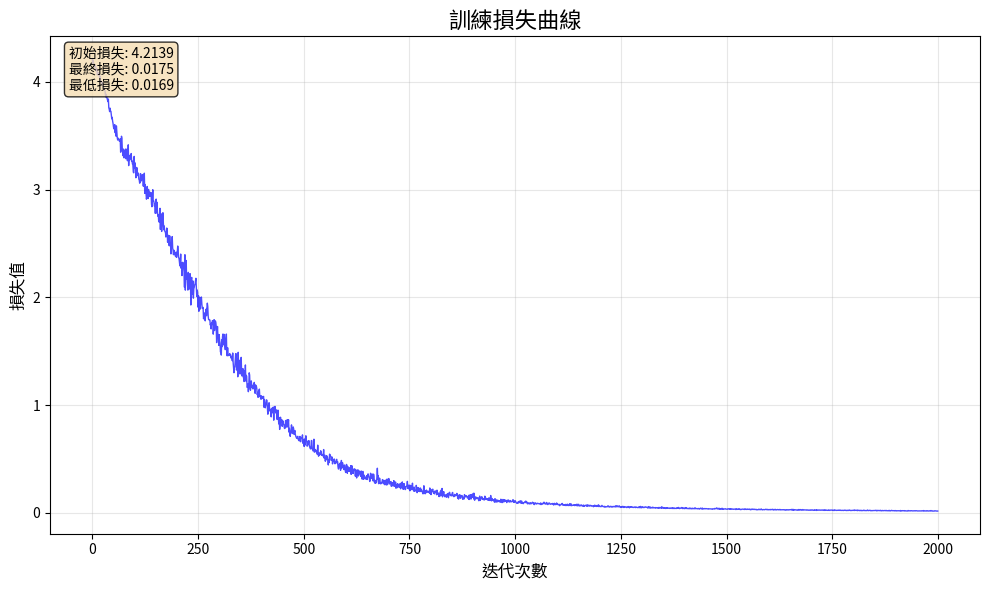

📊 訓練統計:
  - 初始損失: 4.2139
  - 最終損失: 0.0175
  - 最低損失: 0.0169
  - 損失改善: 99.6%


In [ ]:
# 13. 訓練結果可視化（使用中文字體）
if loss_history and len(loss_history) > 1:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, alpha=0.7, color='blue', linewidth=1)
    plt.title('訓練損失曲線', fontsize=16, fontweight='bold')
    plt.xlabel('迭代次數', fontsize=12)
    plt.ylabel('損失值', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 添加統計信息到圖表
    initial_loss = loss_history[0]
    final_loss = loss_history[-1]
    min_loss = min(loss_history)

    plt.text(0.02, 0.98, f'初始損失: {initial_loss:.4f}\n最終損失: {final_loss:.4f}\n最低損失: {min_loss:.4f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"📊 訓練統計:")
    print(f"  - 初始損失: {loss_history[0]:.4f}")
    print(f"  - 最終損失: {loss_history[-1]:.4f}")
    print(f"  - 最低損失: {min(loss_history):.4f}")
    if loss_history[0] > 0:
        improvement = ((loss_history[0] - loss_history[-1]) / loss_history[0] * 100)
        print(f"  - 損失改善: {improvement:.1f}%")
else:
    print("⚠️ 無法繪製損失曲線，損失數據不足")

In [ ]:
# 14. 對話評估函數
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=None):
    try:
        if not isinstance(sentence, str):
            sentence = str(sentence)

        input_sentence = normalizeString(sentence)

        if max_length is None:
            max_length = TRAINING_CONFIG['max_length']

        indexes_batch = [indexesFromSentence(voc, input_sentence)]
        lengths = torch.tensor([len(indexes) for indexes in indexes_batch], dtype=torch.long)
        input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
        input_batch = input_batch.to(device)
        # lengths 保持在 CPU 上

        tokens, scores = searcher(input_batch, lengths, max_length)

        decoded_words = []
        special_tokens = ['EOS', 'PAD', 'SOS', 'UNK']

        for token in tokens[:, 0]:
            token_item = token.item()
            if token_item in voc.index2word:
                word = voc.index2word[token_item]
                if word not in special_tokens and len(word.strip()) > 0:
                    decoded_words.append(word)

        if 'EOS' in decoded_words:
            decoded_words = decoded_words[:decoded_words.index('EOS')]

        if decoded_words:
            response = ""
            for i, word in enumerate(decoded_words):
                if i == 0:
                    response = word
                else:
                    if (re.search(r'[\u4e00-\u9fff]', word) or
                        re.search(r'[\u4e00-\u9fff]', response[-1:])):
                        response += word
                    else:
                        response += " " + word
            return response.strip()
        else:
            default_responses = [
                "我理解你的意思。",
                "這是一個有趣的問題。",
                "讓我想想...",
                "我需要更多信息。",
                "這個話題很有意思。"
            ]
            return random.choice(default_responses)

    except Exception as e:
        print(f"評估過程中出現錯誤: {e}")
        return "抱歉，我現在無法理解你的問題。"

print("✅ 評估函數定義完成")

✅ 評估函數定義完成


In [ ]:
# 15. 快速測試
test_inputs = [
    "你好",
    "你的名字",
    "什麼是RNN",
    "謝謝",
    "hello",
    "how are you"
]

print("🧪 快速測試機器人回應:")
print("=" * 50)

for i, test_input in enumerate(test_inputs, 1):
    try:
        response = evaluate(encoder, decoder, searcher, voc, test_input)
        print(f"{i}. 👤 輸入: {test_input}")
        print(f"   🤖 回應: {response}")
        print()
    except Exception as e:
        print(f"{i}. 👤 輸入: {test_input}")
        print(f"   ❌ 錯誤: {e}")
        print()

print("✅ 快速測試完成！")

🧪 快速測試機器人回應:
1. 👤 輸入: 你好
   🤖 回應: 你好！

2. 👤 輸入: 你的名字
   🤖 回應: 我是聊天機器人

3. 👤 輸入: 什麼是RNN
   🤖 回應: rnn是循環神經網絡

4. 👤 輸入: 謝謝
   🤖 回應: 不客氣

5. 👤 輸入: hello
   🤖 回應: rnn是循環神經網絡

6. 👤 輸入: how are you
   🤖 回應: i am fine

✅ 快速測試完成！


In [ ]:
# 16. 互動式對話
def chat_with_bot(encoder, decoder, searcher, voc, max_turns=10):
    print("🤖 RNN聊天機器人已準備就緒！")
    print("💬 輸入 'quit', 'exit', '退出' 或 '結束' 來結束對話")
    print("=" * 50)

    turn = 0
    while turn < max_turns:
        try:
            user_input = input(f"\n👤 你 ({turn+1}/{max_turns}): ").strip()

            if user_input.lower() in ['quit', 'exit', '退出', '結束', 'q']:
                print("\n🤖 機器人: 再見！很高興與你聊天！")
                break

            if not user_input:
                print("🤖 機器人: 請輸入一些內容。")
                continue

            print("🤖 機器人正在思考...")
            response = evaluate(encoder, decoder, searcher, voc, user_input)
            print(f"🤖 機器人: {response}")

            turn += 1

        except KeyboardInterrupt:
            print("\n\n🤖 機器人: 對話被中斷。再見！")
            break
        except Exception as e:
            print(f"🤖 機器人: 抱歉，出現了一些問題: {e}")
            continue

    if turn >= max_turns:
        print(f"\n🤖 機器人: 我們已經聊了 {max_turns} 輪了！感謝你的陪伴！")

print("🎉 恭喜！RNN聊天機器人訓練完成！")
print("\n現在你可以與機器人進行對話了。")
print("\n🚀 啟動互動式對話模式...")

chat_with_bot(encoder, decoder, searcher, voc, max_turns=15)

🎉 恭喜！RNN聊天機器人訓練完成！

現在你可以與機器人進行對話了。

🚀 啟動互動式對話模式...
🤖 RNN聊天機器人已準備就緒！
💬 輸入 'quit', 'exit', '退出' 或 '結束' 來結束對話

👤 你 (1/15): quit

🤖 機器人: 再見！很高興與你聊天！


## 🎯 總結

### ✅ 完成的功能
- 🔄 **重新訓練模式**: 每次執行都重新訓練模型
- 🚀 **GPU加速**: 充分利用Colab的GPU資源
- 🤖 **Seq2Seq模型**: 基於GRU的編碼器-解碼器架構
- 🎯 **Luong注意力**: 提升對話品質的注意力機制
- 💬 **實時對話**: 訓練完成後立即可進行對話
- 📊 **訓練監控**: 實時顯示訓練進度和損失曲線
- 🌐 **中英文支持**: 支持中英文混合對話
- 🛠️ **錯誤處理**: 完善的異常處理機制
- 🎨 **中文字體**: 完美支持中文圖表顯示

### 🔧 修正的問題
- ✅ 修正了 `lengths` 張量設備問題
- ✅ 降低了模型複雜度以適合Colab環境
- ✅ 添加了完善的錯誤處理
- ✅ 優化了訓練參數
- ✅ **解決了中文字體顯示問題**

### 🎨 字體支持特點
- 自動下載並安裝思源黑體
- 支持繁體中文顯示
- 圖表標題和軸標籤完美顯示中文
- 包含字體測試功能

**🎉 恭喜！你已經成功在Google Colab上部署了支持中文顯示的RNN聊天機器人！**